## Summary
In this notebook, the paired data from MSV000084771 is analysed for the NPClassScore paper.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the MSV000084771 dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading the MSV000084771 dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links

## Loading MSV000084771 dataset

In [3]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../prototype')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.nplinker import Spectrum
from collections import Counter, defaultdict

In [4]:
# load local crusemann data
npl = NPLinker(
    {'dataset':
     {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/'},
    'docker':
     {'run_canopus': True}})
npl.load_data()

13:31:40 [INFO] config.py:121, Loading from local data in directory /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/
13:31:40 [WARNING] loader.py:50, WARNING: unable to find extra_nodes_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/quantification_table_reformatted/*.csv"
13:31:40 [WARNING] loader.py:50, WARNING: unable to find metadata_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/metadata_table/metadata_table*.txt"
13:31:40 [WARNING] loader.py:50, WARNING: unable to find quantification_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/quantification_table/quantification_table*.csv"
13:31:40 [INFO] loader.py:84, Trying to discover correct bigscape directory under /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data

True

In [5]:
# del NPLinker

In [6]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
spectra_in_dataset = [spec for spec in npl.spectra if 'strains=0' not in str(spec)]
print('Spectra:', len(npl.spectra), # contains Spectrum objects
      '({} spectra actually present in currently selected strains in strain_mappings.csv)'.format(len(spectra_in_dataset)))
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'extra_bigscape_parameters': '', 'run_canopus': True}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
../../prototype/nplinker/data

/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/
BGCs: 367
GCFs: 300
Spectra: 11464 (3080 spectra actually present in currently selected strains in strain_mappings.csv)
Molecular Families: 10458


In [7]:
# Count spectra with chemical class info
spectra_in_dataset_with_class = []
spectra_in_dataset_no_class = []
for spec in spectra_in_dataset:
    spec_can = npl.chem_classes.canopus.spectra_classes.get(str(spec.spectrum_id))
    if not spec_can:
        spec_mne = npl.chem_classes.molnetenhancer.spectra_classes(str(spec.spectrum_id))
        if not spec_mne:
            spectra_in_dataset_no_class.append(spec)
        else:
            spectra_in_dataset_with_class.append(spec)
    else:
        spectra_in_dataset_with_class.append(spec)
print(f"From the {len(spectra_in_dataset)} spectra present in current strains, {len(spectra_in_dataset_with_class)} spectra have class info")

From the 3080 spectra present in current strains, 2271 spectra have class info


In [8]:
parent_masses = [spec.parent_mz for spec in spectra_in_dataset]

(array([ 65., 350., 346., 401., 907., 444., 251.,  92.,  19.,  40.,  37.,
          9.,  10.,  20.,  23.,   4.,   9.,   6.,   1.,  46.]),
 array([ 132.02672355,  263.45046573,  394.8742079 ,  526.29795008,
         657.72169226,  789.14543444,  920.56917661, 1051.99291879,
        1183.41666097, 1314.84040314, 1446.26414532, 1577.6878875 ,
        1709.11162968, 1840.53537185, 1971.95911403, 2103.38285621,
        2234.80659839, 2366.23034056, 2497.65408274, 2629.07782492,
        2760.5015671 ]),
 <BarContainer object of 20 artists>)

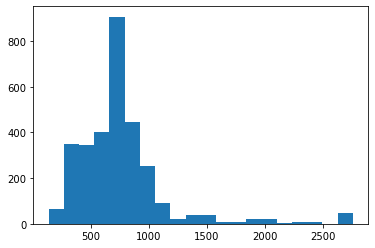

In [9]:
plt.hist(parent_masses, bins=20)

In [10]:
parent_masses_no_pred = [spec.parent_mz for spec in spectra_in_dataset_no_class]

(array([ 14.,  81.,  82.,  75.,  87.,  52., 197.,  65.,  18.,  27.,  34.,
          2.,   4.,   9.,  10.,   1.,   8.,   3.,   1.,  39.]),
 array([ 132.02672355,  263.45046573,  394.8742079 ,  526.29795008,
         657.72169226,  789.14543444,  920.56917661, 1051.99291879,
        1183.41666097, 1314.84040314, 1446.26414532, 1577.6878875 ,
        1709.11162968, 1840.53537185, 1971.95911403, 2103.38285621,
        2234.80659839, 2366.23034056, 2497.65408274, 2629.07782492,
        2760.5015671 ]),
 <BarContainer object of 20 artists>)

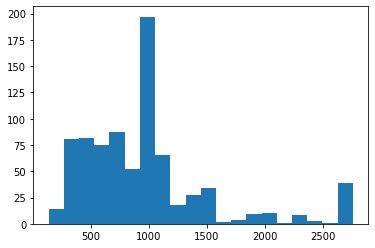

In [11]:
plt.hist(parent_masses_no_pred, bins=20)

## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [12]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

13:32:31 [INFO] methods.py:459, MetcalfScoring.setup (bgcs=367, gcfs=300, spectra=11464, molfams=10458, strains=11)
13:32:32 [INFO] methods.py:499, MetcalfScoring.setup completed
Number of results: 298


In [13]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

13:32:44 [INFO] methods.py:968, Set up NPClassScore scoring
13:32:44 [INFO] methods.py:970, Please choose one of the methods from ['mix', 'main', 'canopus', 'molnetenhancer']
13:32:44 [INFO] methods.py:976, Currently the method 'mix' is selected
13:32:56 [INFO] methods.py:982, Running NPClassScore...
13:32:56 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
13:33:06 [INFO] methods.py:1003, Calculating NPClassScore for 300 objects to 11464 targets (123323 pairwise interactions that share at least 1 strain). This might take a while.
13:33:18 [WARNING] methods.py:1047, 809 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
13:33:18 [INFO] methods.py:1052, NPClassScore completed in 21.8s
Number of results for Metcalf and NPClassScore scoring: 275
{<nplinker.scoring.methods.MetcalfScoring object at 0x7efb4658c208>, <nplinker.scoring.methods.NPClassScoring object at 0x7efb44bf0668>}


In [14]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

13:33:30 [INFO] methods.py:982, Running NPClassScore...
13:33:30 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
13:33:40 [INFO] methods.py:1003, Calculating NPClassScore for 300 objects to 11464 targets (123323 pairwise interactions that share at least 1 strain). This might take a while.
13:33:53 [WARNING] methods.py:1047, 809 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
13:33:53 [INFO] methods.py:1052, NPClassScore completed in 22.3s
Number of results for Metcalf and NPClassScore scoring: 282
{<nplinker.scoring.methods.MetcalfScoring object at 0x7efb4658c208>, <nplinker.scoring.methods.NPClassScoring object at 0x7efb3cdc5b38>}


## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [15]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum) and 'strains=0' not in str(link_data.target)])
    
    # loop through cutoffs
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            # calculate number of links with npcl filtering
            filtered_links = []
            for link_data in results_0.get_sorted_links(mc, gcf):
                if isinstance(link_data.target, Spectrum):
                    npcl_score = npcl_0.format_data(link_data[npcl_0])
                    if npcl_score:
                        if float(npcl_score) > cs_cut:
                            filtered_links.append(link_data)
                    else:
                        if count_nones:
                            filtered_links.append(link_data)
            num_filtered_links = len(filtered_links)
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)

In [16]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	206.33
0.125	98.27	-0.52
0.25	64.35	-0.69
0.375	58.24	-0.72
0.5	45.85	-0.78
0.625	35.17	-0.83
0.75	13.03	-0.94
0.875	6.31	-0.97


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [17]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        if count_nones:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum)])
        else:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) if link_data[npcl]])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(206.32666666666665, 64.34666666666666)

In [18]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.6881320882742576

## Making plots showing the filtered links

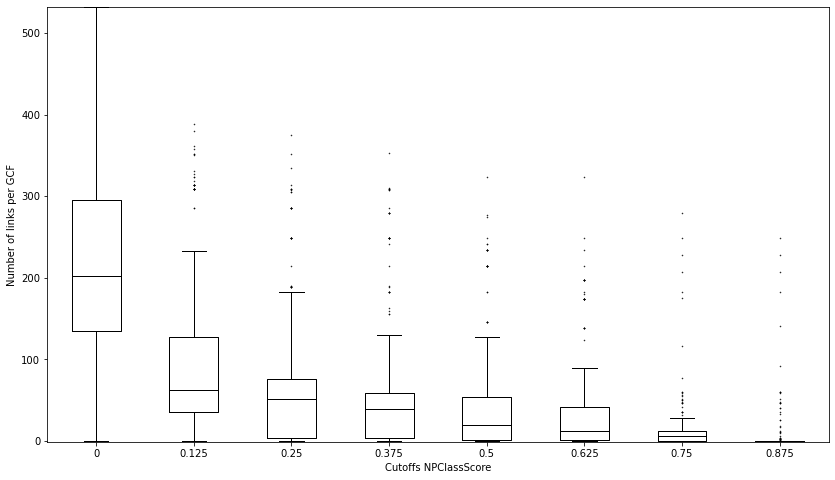

In [19]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_MSV000084771_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction
Bin size: 25


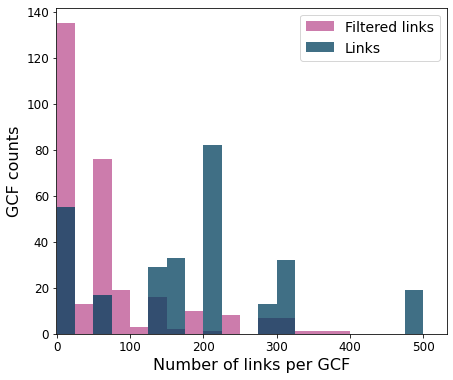

In [20]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
bin_size = 25
print("Bin size:", bin_size)
n_bins = np.arange(0, max(d_all_num_links), bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_MSV000084771_mix_can-mne_figure_new.svg"
plt.savefig(figout)

## Investigate known links

In [21]:
# Nocobactin hits with cblaster
# NC_016887.1.region003
# NZ_BAFR01000032.region001
# NZ_BAGG01000019.region002
# NZ_LMFE01000007.region002
# NZ_BDAX01000006.region001
# NZ_BDBF01000011.region001
# NZ_BDBM01000018.region001
# NZ_BDBU01000023.region001
# NZ_BDCA01000029.region001
# NZ_BDCL01000038.region001
# NZ_BDCU01000023.region001
nocobactin_hits = ['NC_016887.1.region003','NZ_BAFR01000032.region001','NZ_BAGG01000019.region002','NZ_LMFE01000007.region002','NZ_BDAX01000006.region001','NZ_BDBF01000011.region001','NZ_BDBM01000018.region001','NZ_BDBU01000023.region001','NZ_BDCA01000029.region001','NZ_BDCL01000038.region001','NZ_BDCU01000023.region001']

In [22]:
nocobactin_hits_bgcs = [bgc for bgc in npl.bgcs if bgc.name in nocobactin_hits]
nocobactin_hits_bgcs

[BGC(id=1, name=NC_016887.1.region003, strain=Strain(Nocardia cyriacigeorgica GUH-2) [4 aliases], asid=NC_016887.1, region=3),
 BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1),
 BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
 BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1),
 BGC(id=63, name=NZ_BDBF01000011.region001, strain=Strain(Nocardia elegans NBRC 108235) [32 aliases], asid=NZ_BDBF01000011, region=1),
 BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1),
 BGC(id=113, name=NZ_BDCA01000029.region001, strain=Strain(Nocardia vermiculata NBRC 100427) [21 aliases], asid=NZ_BDCA01000029, region=1),
 BGC(id=122, name=NZ_BDCL01000038.region001, stra

In [23]:
known_links_dict = {}

### Mycobactin-like

In [40]:
# nocobactin hit with cblaster found in Nocardia araoensis NBRC 100135
name_hit = 'mycobactin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [8614]  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.3669

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BAFR01000032.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1)]
{GCF(id=10, class=NRPS, gcf_id=25, strains=1)} 1


In [41]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 10][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=10, class=NRPS, gcf_id=25, strains=1),
 StrainCollection(n=1) [Nocardia araoensis NBRC 100135],
 {BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1)})

In [42]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = len(result_links_both)
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=10, class=NRPS, gcf_id=25, strains=1), 135 total links, 1 methods used
Rank above cutoff (original rank)
1.(2)	Spectrum(id=10, spectrum_id=11, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 205.105
1.(2)	Spectrum(id=12, spectrum_id=13, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 205.112
1.(2)	Spectrum(id=54, spectrum_id=55, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 255.101
1.(2)	Spectrum(id=103, spectrum_id=104, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 282.27802
1.(2)	Spec

In [43]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

221 90


### Mycobactin-like (2)

In [44]:
# nocobactin hit with cblaster found in Nocardia takedensis NBRC 100417: NZ_BAGG01000019.region002
name_hit = 'mycobactin takedensis'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [8612]  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.3669

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BAGG01000019.region002"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2)]
{GCF(id=28, class=NRPS, gcf_id=73, strains=2)} 1


In [45]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 28][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=28, class=NRPS, gcf_id=73, strains=2),
 StrainCollection(n=2) [Nocardia takedensis NBRC 100417,Nocardia gamkensis NBRC 108242],
 {BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
  BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)})

In [46]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

In [47]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

221 90


In [48]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Nocardimicin G

In [49]:
# nocobactin hit with cblaster found in Nocardia jejuensis: NZ_BDBU01000023.region001
name_hit = 'nocardimicin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = []  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.3669

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDBU01000023.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1)]
{GCF(id=85, class=Others, gcf_id=225, strains=1)} 1


In [51]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 85][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=85, class=Others, gcf_id=225, strains=1),
 StrainCollection(n=1) [Nocardia jejuensis NBRC 103114],
 {BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1)},
 'Others',
 'NRPS-like.NRPS.terpene')

In [52]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=85, class=Others, gcf_id=225, strains=1), 257 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=2, spectrum_id=3, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 163.14799
1.(1)	Spectrum(id=14, spectrum_id=15, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 211.133
1.(1)	Spectrum(id=25, spectrum_id=26, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 221.19099
1.(1)	Spectrum(id=27, spectrum_id=28, strains=1)	metcalf=3.1623	shared strains=1	MF=46
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 222.222
1.(1)	Spectrum(id=43, spectrum_id=44, strains=1)	metcalf=3.1623	shar

In [53]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

306 176


### Summarise

In [54]:
for k,v in known_links_dict.items():
    print(k,v)
    print()

mycobactin {'hits': [(1, 2, GCF(id=10, class=NRPS, gcf_id=25, strains=1), ObjectLink(source=GCF(id=10, class=NRPS, gcf_id=25, strains=1), target=Spectrum(id=8613, spectrum_id=8614, strains=1), #methods=1))], 'counts': (221, 90)}

nocardimicin {'hits': [], 'counts': (306, 176)}

mycobactin takedensis {'hits': [], 'counts': (221, 90), 'not_found': 'not in metcalf'}

